In [3]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
import re
import json
import string
import numpy as np
import tensorflow as tf
from pprint import pprint
from tensorflow import keras
from tensorflow.keras import layers
from tokenizers import BertWordPieceTokenizer
from transformers import RobertaTokenizer, RobertaTokenizerFast, TFRobertaModel
from tensorflow import keras

tf.random.set_seed(1234)
np.random.seed(1234)

seq_len = 450
max_len = 512

###################
## TRAINING DATA ##
###################
ccc_train = []

with open('/home/ben/GDrive/Projects/distant_crowds/data/ccc_train.jsonl', 'r') as json_file:
    json_list = list(json_file)
for json_str in json_list:
    ccc_train.append(json.loads(json_str))

for ex in ccc_train:
    ex["text"] = " ".join(ex["text"].split())
    ex["size_text"] = " ".join(ex["size_text"].split())

print(f"Training examples from raw data: {len(ccc_train)}")
# ccc_train = [a for a in ccc_train if a["size_text"].lower() in a["text"].lower()]
print(f"Training examples after removing unmatched size_text strings: {len(ccc_train)}")


######################
## SPAN TUNING DATA ##
######################
ccc_tune = []

with open('../data/ccc_span_tune.jsonl', 'r') as json_file:
    json_list = list(json_file)
for json_str in json_list:
    ccc_tune.append(json.loads(json_str))

for ex in ccc_tune:
    ex["para"] = " ".join(ex["para"].split())
    ex["size_text"] = " ".join(ex["size_text"].split())    

print(f"Span tune examples in raw data: {len(ccc_tune)}")
ccc_tune = [a for a in ccc_tune if a["size_text"].lower() in a["para"].lower()]
print(f"Span tune examples after removing unmatched size_text strings: {len(ccc_tune)}")

ccc_tune = {"data":[{"paragraphs":[{"context":qq["para"],
                             "qas":[
                                 {"answers":[{"answer_start":qq["para"].lower().index(qq["size_text"].lower()),
                                              "text":qq["size_text"]}],
                                  "question":"How many people protested?"}
                             ]}]} for qq in ccc_tune]}

##################
## TESTING DATA ##
##################
ccc_test = []

with open('../data/ccc_test_set.jsonl', 'r') as json_file:
    json_list = list(json_file)
for json_str in json_list:
    ccc_test.append(json.loads(json_str))
    
for ex in ccc_test:
    ex["text"] = " ".join(ex["text"].split())
    ex["size_text"] = " ".join(ex["size_text"].split())
    
print(f"Testing examples from raw data: {len(ccc_test)}")
ccc_test = [a for a in ccc_test if a["size_text"].lower() in a["text"].lower()]
print(f"Testing examples after removing unmatched size_text strings: {len(ccc_test)}")

ccc_test = {"data":[{"paragraphs":[{"context":" ".join(qq["text"].split()),
                             "qas":[
                                 {"answers":[{"answer_start":qq["text"].lower().index(qq["size_text"].lower()),
                                              "text":qq["size_text"]}],
                                  "question":"How many people protested?"}
                             ]}]} for qq in ccc_test]}

#####################
## VALIDATION DATA ##
#####################
ccc_valid = []

with open('../data/ccc_validation_set.jsonl', 'r') as json_file:
    json_list = list(json_file)
for json_str in json_list:
    ccc_valid.append(json.loads(json_str))
    
for ex in ccc_valid:
    ex["text"] = " ".join(ex["text"].split())
    ex["size_text"] = " ".join(ex["size_text"].split())
    
print(f"Valid examples from raw data: {len(ccc_valid)}")
ccc_valid = [a for a in ccc_valid if a["size_text"].lower() in a["text"].lower()]
print(f"Valid examples after removing unmatched size_text strings: {len(ccc_valid)}")

ccc_valid = {"data":[{"paragraphs":[{"context":" ".join(qq["text"].split()),
                             "qas":[
                                 {"answers":[{"answer_start":qq["text"].lower().index(qq["size_text"].lower()),
                                              "text":qq["size_text"]}],
                                  "question":"How many people protested?"}
                             ]}]} for qq in ccc_valid]}

########################
## SOFT-LABELED TRAIN ##
########################
soft_train = []

with open('../data/soft_labeled_train.jsonl', 'r') as json_file:
    json_list = list(json_file)
for json_str in json_list:
    soft_train.append(json.loads(json_str))
    
for ex in soft_train:
    ex["context"] = " ".join(ex["context"].split())
    ex["labeled_text"] = " ".join(ex["labeled_text"].split())
    
# print(f"Soft examples from raw data: {len(soft_train)}")
# soft_train = [a for a in soft_train if a["labeled_text"].lower() in a["context"].lower()]
# print(f"Soft examples after removing unmatched size_text strings: {len(soft_train)}")

# soft_train = {"data":[{"paragraphs":[{"context":" ".join(qq["context"].split()),
#                              "qas":[
#                                  {"answers":[{"answer_start":qq["context"].lower().index(qq["labeled_text"].lower()),
#                                               "text":qq["labeled_text"]}],
#                                   "question":"How many people protested?"}
#                              ]}]} for qq in soft_train]}

#########################
## TOKENIZER AND MODEL ##
#########################

tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")



FileNotFoundError: [Errno 2] No such file or directory: 'data/how-3.0.1.csv'

In [ ]:
x_cat_inputs = []
x_cat_attentions = []
x_cat_types = []
y_cat = []
y_start = []
y_end = []

for ii, ex in enumerate(ccc_train):
    text = ex["text"]
    answer = soft_train[ii]["labeled_text"]
    
    tokenized_context = tokenizer(text, return_offsets_mapping=True)
    tokenized_question = tokenizer("</s> How many people protested?", return_offsets_mapping=True)
    
    if len(tokenized_context.input_ids) > seq_len:
        continue
    
    ########################
    ## MERGE IN SOFT SPAN ##
    ########################
    try:
        start_char_idx = text.lower().index(answer.lower())
    except:
        continue
    
    # Find end character index of answer in context
    end_char_idx = start_char_idx + len(answer)

    # Mark the character indexes in context that are in answer
    is_char_in_ans = [0] * len(text)
    for idx in range(start_char_idx, end_char_idx):
        is_char_in_ans[idx] = 1

    # Find tokens that were created from answer characters
    ans_token_idx = []
    for idx, (start, end) in enumerate(tokenized_context.offset_mapping):
        if sum(is_char_in_ans[start:end]) > 0:
            ans_token_idx.append(idx)

    # Find start and end token index for tokens from answer
    start_token_idx = ans_token_idx[0]
    end_token_idx = ans_token_idx[-1]
    y_start.append(start_token_idx)
    y_end.append(end_token_idx)
    #######################
    ##                   ##
    #######################                                    
    
    context_ids = tokenized_context.input_ids[0:-1]
    question_ids = tokenized_question.input_ids[1:]
    input_ids = context_ids + question_ids
    
    padding = [0]*(max_len - len(input_ids))
    
    input_ids = input_ids + (np.array(padding)+1).tolist()
    attention_mask = [1]*len(context_ids) + [1]*len(question_ids) + [0]*len(padding)
    token_type_ids = [0]*len(context_ids) + [1]*len(question_ids) + [1]*len(padding)
    
    x_cat_inputs.append(input_ids)
    x_cat_attentions.append(attention_mask)
    x_cat_types.append(token_type_ids)
    y_cat.append(ex["size_cat"])

x_cat = (np.array(x_cat_inputs),
         np.array(x_cat_types),
         np.array(x_cat_attentions))
y_cat = (np.array(y_cat),
         np.array(y_start),
         np.array(y_end))
print(len(x_cat_inputs))

In [3]:
class SquadExample:
    def __init__(self, question, context, start_char_idx, answer_text, all_answers, seq_len, max_len):
        
        # Clean context, answer and question
        context = " ".join(str(context).split())
        question = " ".join(str(question).split())
        answer = " ".join(str(answer_text).split())

        self.question = str(question)
        self.context = str(context)
        self.start_char_idx = start_char_idx
        self.answer_text = str(answer)
        self.all_answers = all_answers
        self.max_len = max_len
        self.seq_len = seq_len
        self.skip_doc = False
        
        self.input_ids = None
        self.attention_mask = None
        self.token_type_ids = None
        self.start_token_idx = None
        self.end_token_idx = None
        self.skip = None
        
    def __str__(self):
        print(np.stack(self.input_ids).shape)
        print(np.stack(self.token_type_ids).shape)
        print(np.stack(self.attention_mask).shape)
        return "<SquadExample>"
        
    def __repr__(self):
        return repr({"input_ids":self.input_ids, 
                     "token_type_ids":self.token_type_ids, 
                     "attention_mask":self.attention_mask,
                     "start_token_idx":self.start_token_idx,
                     "end_token_idx":self.end_token_idx,
                     "skip":self.skip})

    def preprocess(self):
        context = self.context
        question = self.question
        answer = self.answer_text
        start_char_idx = self.start_char_idx

        # Find end character index of answer in context
        end_char_idx = start_char_idx + len(answer)
        if (end_char_idx >= len(context)) or (start_char_idx < 0):
            self.skip_doc = True
            return

        # Mark the character indexes in context that are in answer
        is_char_in_ans = [0] * len(context)
        for idx in range(start_char_idx, end_char_idx):
            is_char_in_ans[idx] = 1
            
        # Tokenize context
        tokenized_context = tokenizer(context, return_offsets_mapping=True)
        
        context_input_ids = tokenized_context.input_ids
        context_offset_mapping = tokenized_context.offset_mapping
        context_attention_mask = tokenized_context.attention_mask
        
        self.context_input_ids = context_input_ids
        self.context_offset_mapping = context_offset_mapping
        
        # Find tokens that were created from answer characters
        ans_token_idx = []
        for idx, (start, end) in enumerate(context_offset_mapping):
            if sum(is_char_in_ans[start:end]) > 0:
                ans_token_idx.append(idx)

#         if len(ans_token_idx) == 0:
#             self.skip_doc = True
#             return
        if (len(ans_token_idx) == 0):
            ans_token_idx = [-1]

        # Find start and end token index for tokens from answer
        start_token_idx = ans_token_idx[0]
        end_token_idx = ans_token_idx[-1]
        
        self.start_token_idx_master = start_token_idx
        self.end_token_idx_master = end_token_idx
        
        # Tokenize question
        tokenized_question = tokenizer("</s> "+question, return_offsets_mapping=True)
        
        ## Crop start and end tokens
        question_input_ids = tokenized_question.input_ids[1:]
        context_input_ids = context_input_ids[1:-1]

        ##
        ## SPLIT UP CONTEXT INTO MULTIPLE QUESTIONS OF max_len
        ##
        
        if seq_len >= len(context_input_ids):
            offsets = [0]
        else:
            ii = 0
            offsets = []
            while (ii+seq_len) <= len(context_input_ids):
                offsets.append(ii)
                ii = ii + round(seq_len/2)
            offsets = offsets + [len(context_input_ids)-seq_len]
        
        list_input_ids = []
        list_start_token_idx = []
        list_end_token_idx = []
        list_attention_mask = []
        list_token_type_ids = []
        list_skip = []
        
        for ii in offsets:
            subcontext_input_ids = [0]+context_input_ids[ii:(ii+seq_len)]+question_input_ids
            subcontext_start_token_idx = start_token_idx - ii
            subcontext_end_token_idx = end_token_idx - ii
            subcontext_padding = [0] * (self.max_len - len(subcontext_input_ids))
            
            subcontext_attention_mask = [1] * len(subcontext_input_ids) + subcontext_padding
            subcontext_token_type_ids = [0] + [0]*len(context_input_ids[ii:(ii+seq_len)]) + [1]*len(question_input_ids) + (np.array(subcontext_padding)+1).tolist()
            subcontext_input_ids = subcontext_input_ids + (np.array(subcontext_padding)+1).tolist()
            
            if (subcontext_start_token_idx >= 0) and (subcontext_end_token_idx < seq_len):
                skip = False
            else:
                subcontext_start_token_idx = 0
                subcontext_end_token_idx = 0
                skip = False
                
            list_input_ids.append(subcontext_input_ids)
            list_attention_mask.append(subcontext_attention_mask)
            list_token_type_ids.append(subcontext_token_type_ids)
            list_start_token_idx.append(subcontext_start_token_idx)
            list_end_token_idx.append(subcontext_end_token_idx)
            list_skip.append(skip)
        
        self.input_ids = (list_input_ids)
        self.attention_mask = (list_attention_mask)
        self.token_type_ids = (list_token_type_ids)
        self.start_token_idx = (list_start_token_idx)
        self.end_token_idx = (list_end_token_idx)
        self.skip = list_skip
        self.example_offset = offsets
        
    def train_examples(self, include_impossible=False):
        for idx, skip_ex in enumerate(self.skip):
            if include_impossible is False:
                if skip_ex is False:
                    yield  {"input_ids":self.input_ids[idx],
                            "token_type_ids":self.token_type_ids[idx],
                            "attention_mask":self.attention_mask[idx],
                            "start_token_idx":self.start_token_idx[idx],
                            "end_token_idx":self.end_token_idx[idx]}
            else:
                yield  {"input_ids":self.input_ids[idx],
                            "token_type_ids":self.token_type_ids[idx],
                            "attention_mask":self.attention_mask[idx],
                            "start_token_idx":self.start_token_idx[idx],
                            "end_token_idx":self.end_token_idx[idx]}
    
    
    def inference_from_onehot(self, pred_start, pred_end):

#         if force_answer == False:
        if (np.max(np.argmax(pred_start, axis=1)) == 0) and (np.max(np.argmax(pred_end, axis=1)) == 0):
            return("", {"all_answers":self.all_answers,
                        "start_token_pred":-1, 
                        "end_token_pred":-1, 
                        "start_char_pred":-1, 
                        "end_char_pred":-1,
                        "start_token":self.start_token_idx_master,
                        "end_token":self.end_token_idx_master,
                        "tokens_pred":set(list([])),
                        "tokens":set(list(range(self.start_token_idx_master,(self.end_token_idx_master+1))))})
        
        seq_len = min(self.seq_len, len(self.context_input_ids))
        
        pred_start_matrix = np.zeros((len(self.input_ids), len(self.context_input_ids)))
        pred_end_matrix = np.zeros((len(self.input_ids), len(self.context_input_ids)))
        
        for idx, value in enumerate(pred_start):
            offset = self.example_offset[idx]+1
            pred_start_sub = pred_start[idx][1:seq_len]
            pred_end_sub   = pred_end[idx][1:seq_len]
            pred_start_matrix[idx,(offset):(offset+seq_len-1)] = pred_start_sub
            pred_end_matrix[idx,(offset):(offset+seq_len-1)] = pred_end_sub
            
        highest_prob = np.argmax(np.max(pred_start_matrix, axis=1) + np.max(pred_end_matrix, axis=1))
        
        top_start = np.argmax(pred_start_matrix[highest_prob,:])
        top_end   = np.argmax(pred_end_matrix[highest_prob,:])
        
#         pred_start = np.max(pred_start_matrix, axis=0)
#         pred_end   = np.max(pred_end_matrix, axis=0)
        
#         top_start = np.argmax(pred_start)
#         top_end = np.argmax(pred_end)
        
        start_char = self.context_offset_mapping[top_start][0]
        end_char = self.context_offset_mapping[top_end][1]
        
        return (self.context[start_char:end_char], {"all_answers":self.all_answers,
                                                    "start_token_pred":top_start, 
                                                    "end_token_pred":top_end, 
                                                    "start_char_pred":start_char, 
                                                    "end_char_pred":end_char,
                                                    "start_token":self.start_token_idx_master,
                                                    "end_token":self.end_token_idx_master,
                                                    "tokens_pred":set(list(range(top_start,(top_end+1)))),
                                                    "tokens":set(list(range(self.start_token_idx_master,(self.end_token_idx_master+1))))})
                
    def model_inference(self, model):
        pred = model.predict([np.stack(self.input_ids),
                      np.stack(self.attention_mask),
                      np.stack(self.token_type_ids)], batch_size=8)
        pred_start = pred[0]
        pred_end   = pred[1]
        
        return self.inference_from_onehot(pred_start, pred_end)
    
    def fake_inference(self):
        pred_start_mat = []
        pred_end_mat = []
        for idx, val in enumerate(self.start_token_idx):
            pred_start = np.zeros_like(np.array(self.input_ids[idx]))
            pred_end = np.zeros_like(np.array(self.input_ids[idx]))
            if self.skip[idx] == False:
                pred_start[val] = 1.0
                pred_end[self.end_token_idx[idx]] = 1.0
            pred_start_mat.append(pred_start)
            pred_end_mat.append(pred_end)
            
        pred_start_mat = np.array(pred_start_mat)
        pred_end_mat = np.array(pred_end_mat)
        
        return self.inference_from_onehot(pred_start_mat,pred_end_mat)
        

def create_squad_examples(raw_data, seq_len, max_len):
    squad_examples = []
    for item in raw_data["data"]:
        for para in item["paragraphs"]:
            context = para["context"]
            for qa in para["qas"]:
                if len(qa["answers"]) > 0:
                    question = qa["question"]
                    answer_text = qa["answers"][0]["text"]
                    all_answers = [_["text"] for _ in qa["answers"]]
                    start_char_idx = qa["answers"][0]["answer_start"]
                    squad_eg = SquadExample(
                        question, context, start_char_idx, answer_text, all_answers, seq_len, max_len
                    )
                    squad_eg.preprocess()
                    squad_examples.append(squad_eg)
                else:
                    question = qa["question"]
                    answer_text = ""
                    all_answers = [""]
                    start_char_idx = 0
                    squad_eg = SquadExample(
                        question, context, start_char_idx, answer_text, all_answers, seq_len, max_len
                    )
                    squad_eg.preprocess()
                    squad_examples.append(squad_eg)
    return squad_examples


def create_inputs_targets(squad_examples, include_impossible=False):
    dataset_dict = {
        "input_ids": [],
        "token_type_ids": [],
        "attention_mask": [],
        "start_token_idx": [],
        "end_token_idx": [],
    }
    for item in squad_examples:
        if item.skip_doc is False:
            for example in item.train_examples(include_impossible):
                for key in dataset_dict:
                    dataset_dict[key].append(np.array(example[key]))
    for key in dataset_dict:
        dataset_dict[key] = np.array(dataset_dict[key])

    x = (
        dataset_dict["input_ids"],
        dataset_dict["token_type_ids"],
        dataset_dict["attention_mask"])
    y = (dataset_dict["start_token_idx"], dataset_dict["end_token_idx"])
    return x, y


def merge_squad_results(squad_examples, start_preds, end_preds):
    ii = 0
    tally = []
    answers = []
    f1_list = []
    for ex in squad_examples:
        if ex.skip_doc is False:
            n_sub = len(ex.skip)
            pred_out = ex.inference_from_onehot(start_preds[ii:(ii+n_sub),:], end_preds[ii:(ii+n_sub),:])
            tally.append(pred_out[0].lower() in [a.lower() for a in ex.all_answers])
            answers.append(pred_out)
            tp = len(pred_out[1]["tokens_pred"].intersection(pred_out[1]["tokens"]))
            fp = len(pred_out[1]["tokens_pred"].difference(pred_out[1]["tokens"]))
            fn = len(pred_out[1]["tokens"].difference(pred_out[1]["tokens_pred"]))
            ii = ii + n_sub
            if tp>0:
                precision = tp/(tp+fp)
                recall=tp/(tp+fn)
                f1_list.append((2*precision*recall)/(precision+recall))
            else:
                f1_list.append(0)
    return (np.mean(tally), 
            np.mean(f1_list), 
            answers)


# train_squad_examples = create_squad_examples(raw_train_data, seq_len, max_len)
# x_train, y_train = create_inputs_targets(train_squad_examples)
# print(f"{len(train_squad_examples)} docs, {x_train.shape[0]} training points created.")


span_examples = create_squad_examples(ccc_tune, seq_len, max_len)
x_span, y_span = create_inputs_targets(span_examples)
print(f"{len(span_examples)} docs, {x_span[0].shape} span points created.")

test_examples = create_squad_examples(ccc_test, seq_len, max_len)
x_test, y_test = create_inputs_targets(test_examples)
print(f"{len(test_examples)} docs, {x_test[0].shape} test points created.")

valid_examples = create_squad_examples(ccc_valid, seq_len, max_len)
x_valid, y_valid = create_inputs_targets(valid_examples)
print(f"{len(valid_examples)} docs, {x_valid[0].shape} valid points created.")


25 docs, (25, 512) span points created.
925 docs, (3306, 512) test points created.
200 docs, (725, 512) valid points created.


# Train and Validate

In [4]:
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

with strategy.scope():
    model = keras.models.load_model('./roberta_base_squad2_512in')
model.summary()

def makeMask(x):
    x_cumsum = tf.math.cumsum(x[0], axis=1)
    y_cumsum = tf.math.cumsum(x[1], axis=1, reverse=True)
    prod = tf.math.multiply(x_cumsum, y_cumsum)
    return prod

# def makeMask(x):
#     x_argmax = tf.math.argmax(x[0], axis=1)
#     y_argmax = tf.math.argmax(x[1], axis=1)
#     x_onehot = tf.one_hot(x_argmax, 512, axis=1)
#     y_onehot = tf.one_hot(y_argmax, 512, axis=1)
#     x_cumsum = tf.cumsum(x_onehot, axis=1)
#     y_cumsum = tf.cumsum(y_onehot, axis=1, reverse=True)
#     prod = tf.math.multiply(x_cumsum,y_cumsum)
#     return prod

def expandDims(x):
    return tf.expand_dims(x,2)

with strategy.scope():
    out_start = model.get_layer("activation_4").output
    out_end = model.get_layer("activation_5").output
    span_mask = layers.ActivityRegularization(l1=0.01)(layers.Lambda(makeMask)([out_start,out_end]))
    span_mask_2d = layers.Lambda(tf.tile, arguments={'multiples':(1,1,768)})(layers.Lambda(expandDims)(span_mask))
    roberta_embedding = model.get_layer("roberta").output["last_hidden_state"]
    masked_embedding = layers.Multiply()([span_mask_2d,roberta_embedding])
    
    avg_layer = layers.GlobalMaxPooling1D(data_format="channels_last")(masked_embedding)
    out_count = layers.Dense(1, activation="linear")(avg_layer)

    new_optimizer = keras.optimizers.Adam(lr=(5e-5))
    model_cat = keras.models.Model(inputs=[model.input],outputs=[out_count])
    model_cat.compile(optimizer=new_optimizer, 
                      loss=["mean_squared_error"])
    
    model_mask = keras.models.Model(inputs=[model.input],outputs=[span_mask])
    
model_cat.summary()

keras.backend.set_value(model.optimizer.learning_rate, (5e-6))
keras.backend.set_value(model_cat.optimizer.learning_rate, (5e-6))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:

In [5]:
pred_start_v, pred_end_v = model.predict((x_valid[0], x_valid[1], x_valid[2]), batch_size=36, verbose=1)
valid_acc = merge_squad_results(valid_examples, pred_start_v, pred_end_v)

pred_start_t, pred_end_t = model.predict((x_test[0], x_test[1], x_test[2]), batch_size=36, verbose=1)
test_acc = merge_squad_results(test_examples, pred_start_t, pred_end_t)

print(f"Validation set accuracy (EM): {valid_acc[0]}")
print(f"Test set accuracy (EM): {test_acc[0]}")
print(f"Validation set F1: {valid_acc[1]}")
print(f"Test set F1: {test_acc[1]}")

92/92 [==============================] - 26s 287ms/step
Validation set accuracy (EM): 0.19
Test set accuracy (EM): 0.16972972972972972
Validation set F1: 0.27271624189581933
Test set F1: 0.2658847892310077


In [6]:
log_list = []

batch_size = 12


for ii in range(75):
    print(f"ITERATION: {ii} of 75.")
    
#     valid_loss = model.evaluate((x_valid[0],
#                             x_valid[1],
#                             x_valid[2]),
#                             y_valid,
#                            verbose=1,
#                            batch_size=36,
#                            return_dict=True)
#     pred_start, pred_end = model.predict((x_valid[0], x_valid[1], x_valid[2]), batch_size=36, verbose=1)
#     valid_acc = merge_squad_results(valid_examples, pred_start, pred_end)[0]
    
#     print(f"ACCURACY: {valid_acc}")
    
#     validation_loss.append(valid_loss)
#     validation_accuracy.append(valid_acc)
#     batch.append(ii*2)
    
    cat_ii = np.random.choice(range(x_cat[0].shape[0]), batch_size, replace=True)
    
    model_cat.fit(
        (x_cat[0][cat_ii,:],
         x_cat[1][cat_ii,:],
         x_cat[2][cat_ii,:]),
        (y_cat[0][cat_ii]),
        epochs=1,  # For demonstration, 3 epochs are recommended
        verbose=1,
        batch_size=batch_size,  # Made this smaller. Bump up.
    )
    
    cat_ii = np.random.choice(range(x_cat[0].shape[0]), batch_size, replace=True)
    
    model_cat.fit(
        (x_cat[0][cat_ii,:],
         x_cat[1][cat_ii,:],
         x_cat[2][cat_ii,:]),
        (y_cat[0][cat_ii]),
        epochs=1,  # For demonstration, 3 epochs are recommended
        verbose=1,
        batch_size=batch_size,  # Made this smaller. Bump up.
    )
  
    
# valid_loss = model.evaluate((x_valid[0],
#                             x_valid[1],
#                             x_valid[2]),
#                             y_valid[0],
#                            verbose=1,
#                            batch_size=36,
#                            return_dict=True)

# pred_start, pred_end = model.predict((x_valid[0], x_valid[1], x_valid[2]), batch_size=36, verbose=1)
# valid_acc = merge_squad_results(valid_examples, pred_start, pred_end)[0]

# validation_loss.append(valid_loss)
# validation_accuracy.append(valid_acc)
# batch.append(ii*2)

ITERATION: 0 of 75.
INFO:tensorflow:batch_all_reduce: 200 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 200 all-reduces wi

In [7]:
import pandas as pd

stats = pd.DataFrame(log_list)
stats.to_csv("results/roberta_base_squad2_512in_sizecats_75ii.csv")
model.save("roberta_base_squad2_512in_sizecats_75ii")
model_cat.save("roberta_base_squad2_512in_sizecats_75ii_auxiliary")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: roberta_base_squad2_512in_sizecats_75ii/assets
INFO:tensorflow:Assets written to: roberta_base_squad2_512in_sizecats_75ii_auxiliary/assets


In [8]:
pred_start_v, pred_end_v = model.predict((x_valid[0], x_valid[1], x_valid[2]), batch_size=36, verbose=1)
valid_acc = merge_squad_results(valid_examples, pred_start_v, pred_end_v)

pred_start_t, pred_end_t = model.predict((x_test[0], x_test[1], x_test[2]), batch_size=36, verbose=1)
test_acc = merge_squad_results(test_examples, pred_start_t, pred_end_t)

print(f"Validation set accuracy (EM): {valid_acc[0]}")
print(f"Test set accuracy (EM): {test_acc[0]}")
print(f"Validation set F1: {valid_acc[1]}")
print(f"Test set F1: {test_acc[1]}")

pd.DataFrame([{"model":"roberta_base_squad2_512in_sizecats_75ii",
              "f1_valid":valid_acc[1],"f1_test":test_acc[1],
              "em_valid":valid_acc[0],"em_test":test_acc[0]}]).to_csv("results/roberta_f1v_f1t_emv_emt.csv",mode="a",header=False)

92/92 [==============================] - 28s 302ms/step
Validation set accuracy (EM): 0.54
Test set accuracy (EM): 0.4789189189189189
Validation set F1: 0.5847380952380952
Test set F1: 0.5388766759073168


## Check Some Results, Baby!

In [4]:
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

with strategy.scope():
    model = keras.models.load_model('./roberta_base_squad2_512in_sizecats_75ii_auxiliary')
model.summary()

model_span = keras.Model(inputs=[model.input], outputs=[model.get_layer("activation_4").output,
                                                        model.get_layer("activation_5").output,
                                                        model.get_layer("dense").output,
                                                        model.get_layer("lambda_2").output])

pred_start_t, pred_end_t, count, mask = model_span.predict((x_test[0], x_test[1], x_test[2]), batch_size=36, verbose=1)
test_acc = merge_squad_results(test_examples, pred_start_t, pred_end_t)
print(test_acc[0])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 512)]        0                                            
________________________________________

In [5]:
ex = 2
print(np.argmax(pred_start_t[ex]))
list(zip(list(range(len(pred_start_t[ex]))),[tokenizer.decode(a) for b in test_examples[ex].input_ids for a in b], pred_start_t[ex], pred_end_t[ex]))

17


[(0, '<s>', 0.0017821961, 0.0013819395),
 (1, 'On', 0.00022340332, 2.7936077e-05),
 (2, ' Saturday', 0.00020752782, 0.0006987394),
 (3, ' a', 3.9663166e-05, 1.6917513e-05),
 (4, ' few', 0.019136457, 0.0057353755),
 (5, ' hundred', 0.00014421952, 4.9694598e-05),
 (6, ' people', 0.00047158464, 0.0030511578),
 (7, ' gathered', 8.508895e-05, 0.0014301273),
 (8, ' on', 0.00015592882, 5.5559645e-05),
 (9, ' Church', 2.1528417e-06, 7.817577e-06),
 (10, ' Street', 1.8675232e-06, 7.1229415e-06),
 (11, ' in', 1.889356e-05, 2.5879335e-05),
 (12, ' Burlington', 2.5621619e-06, 1.1307937e-05),
 (13, ',', 1.6975662e-05, 0.00015797431),
 (14, ' protesting', 0.00012937942, 0.00019683295),
 (15, ' the', 0.00037901747, 0.00014655798),
 (16, ' recent', 0.0006635604, 0.0001376647),
 (17, ' arrests', 0.8564035, 0.8309346),
 (18, ' of', 8.347271e-05, 0.0008213651),
 (19, ' two', 0.00014542844, 0.0001747006),
 (20, ' immigrants', 0.00091880077, 0.00045458868),
 (21, ' and', 4.002781e-05, 0.00013756363),
 (22,

1/1 [==============================] - 0s 2ms/step


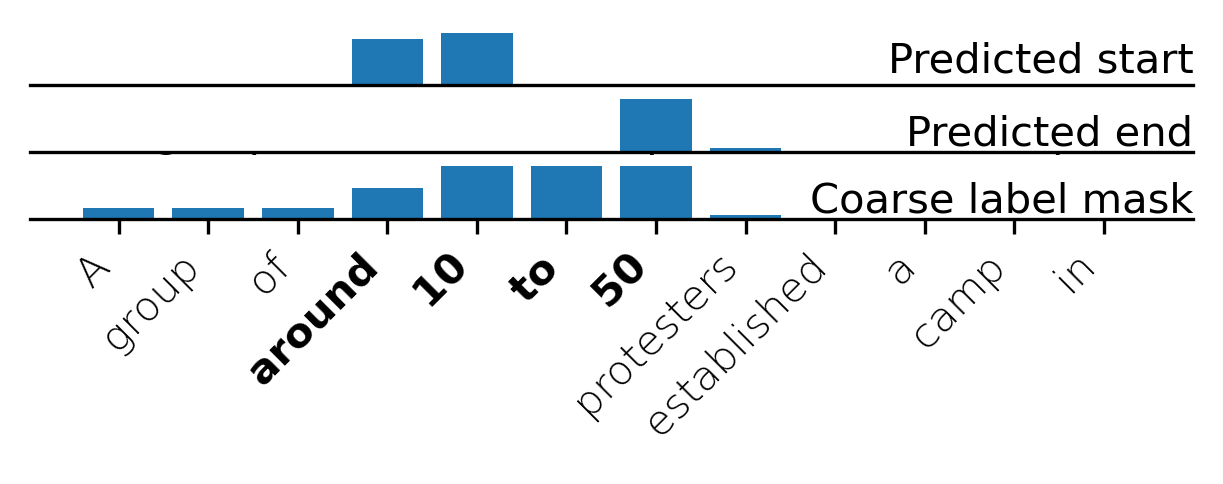

In [22]:
import matplotlib.pyplot as plt


ex = 46
keys = ["input_ids","token_type_ids","attention_mask"]
a,b,c = [next(test_examples[ex].train_examples())[k] for k in keys]

pred_s,pred_e,pred_z,pred_m = model_span.predict((np.array([a]),np.array([b]),np.array([c])), verbose=1, batch_size=36)
start_max = np.argmax(pred_s)

fig, axs = plt.subplots(3, figsize=(5,(5/6)), dpi=300)
# fig.suptitle('Vertically stacked subplots')
axs[0].bar([tokenizer.decode(ii) for ii in a][start_max-4:start_max+8],pred_s[0,start_max-4:start_max+8], log=False)
axs[0].text(12,0.1,"Predicted start", ha="right")
axs[1].bar([tokenizer.decode(ii) for ii in a][start_max-4:start_max+8],pred_e[0,start_max-4:start_max+8], log=False)
axs[1].text(12,0.1,"Predicted end", ha="right")
axs[2].bar([tokenizer.decode(ii) for ii in a][start_max-4:start_max+8],pred_m[0,start_max-4:start_max+8].flatten(), log=False)
axs[2].text(12,0.1,"Coarse label mask", ha="right")
# Hide the right and top spines
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].spines['left'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].spines['left'].set_visible(False)
axs[2].spines['right'].set_visible(False)
axs[2].spines['top'].set_visible(False)
axs[2].spines['left'].set_visible(False)
axs[0].get_yaxis().set_visible(False)
axs[1].get_yaxis().set_visible(False)
axs[2].get_yaxis().set_visible(False)
axs[0].tick_params(bottom=False)
axs[1].tick_params(bottom=False)
# axs[2].tick_params(bottom=False)
plt.setp(axs[2].xaxis.get_majorticklabels(), rotation=45, ha="right")
for ii in list(range(0,12)):
    axs[2].get_xticklabels()[ii].set_weight("light")
for ii in list(range(test_examples[ex].start_token_idx_master - start_max + 4,
                     test_examples[ex].end_token_idx_master - start_max + 5)):
    axs[2].get_xticklabels()[ii].set_weight("bold")

plt.savefig("results/sizecats_example.pdf", bbox_inches="tight")



In [11]:
test_examples[ex].start_token_idx_master

85

In [24]:
tokenizer.encode("<s>This is a test")

[0, 0, 713, 16, 10, 1296, 2]